In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
string = "/content/drive/MyDrive/DOCEREE"
contents = os.listdir('/content/drive/MyDrive/DOCEREE')
contents

['Doceree-HCP_Test.csv',
 'Doceree-HCP_Train.csv',
 '.ipynb_checkpoints',
 'submission.csv',
 'DOCEREE.ipynb']

# Importing the train and test datasets

In [113]:
trainpath = os.path.join(string, contents[1])
traindata = pd.read_csv(trainpath, encoding = 'latin-1')
traindata = traindata[["KEYWORDS", "IS_HCP"]]
traindata = traindata.dropna()

testpath = os.path.join(string, contents[0])
testdata = pd.read_csv(testpath, encoding = 'latin-1')
testdata = testdata[["ID", "KEYWORDS"]]
testdata = testdata.dropna()

In [114]:
traindata

,KEYWORDS,IS_HCP
0,General|Endocrine|False|Medicine|Surgery|Urolo...,0.0
1,Bone Marrow|Radiography|Chronic|Oncology|Psych...,0.0
2,General|Endocrine|False|Medicine|Surgery|Urolo...,0.0
3,Dental|Total|Clinical|Pharmacology|Physicians|...,1.0
4,Critical Care|Emergency Medicine|General Pract...,0.0
...,...,...
113932,Cardiovascular|Clinical|False|Male|Oncology|Ps...,1.0
113933,Asthma|Arthritis|General|Clinical|Diagnosis|Rh...,1.0
113934,Rehabilitation|Transplantation|Clinical|Preven...,1.0
113935,pain|disease|autoimmune|multiple sclerosis|gra...,1.0


In [115]:
testdata

,ID,KEYWORDS
0,115501,Family Practice|Drainage|Clinical|Dermatology|...
1,115502,General|Clinical|Operative|Medicine|Cardiology...
2,115503,Abortion|Anxiety Disorders|Apnea|False|Trauma|...
3,115504,Health|Male|Neurological Surgery|Otolaryngolog...
4,115505,chronic kidney disease|pain|nephrology|disease...
...,...,...
28488,143989,Transplantation|Psychiatry|Heart Failure|Angio...
28489,143990,small|hospitals|nephrology|emergency medicine|...
28490,143991,small|hospitals|nephrology|emergency medicine|...
28491,143992,the|disease|pain|radiology|lung abscess|dyspar...


In [116]:
len(traindata)

113936

In [117]:
len(testdata)

28493

## Data Preprocessing

The keywords are preferably chosen as the medium to train the classification model. Now we get rid of all the punctuations, numbers and special characters to make the data suitable for the vectorizer and the data to be utterly meaningful.

In [118]:
def preprocessing(text):

  #convert to lowercase
  text = text.lower()

  #remove the punctuations
  text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)

  #removing the numbers
  number_pattern = r'\d+'
  text = re.sub(pattern=number_pattern, repl=" ", string=text)

  #removing the extra white spaces
  single_char_pattern = r'\s+[a-zA-Z]\s+'
  text = re.sub(pattern=single_char_pattern, repl=" ", string=text)

  #lemmatizing
  lemmatizer = WordNetLemmatizer()
  tokens = word_tokenize(text)
  for i in range(len(tokens)):
      lemma_word = lemmatizer.lemmatize(tokens[i])
      tokens[i] = lemma_word
  text = " ".join(tokens)



  return text

traindata["KEYWORDS"] = traindata['KEYWORDS'].apply(lambda x: preprocessing(x))
testdata['KEYWORDS'] = testdata["KEYWORDS"].apply(lambda x: preprocessing(x))

In [119]:
traindata

,KEYWORDS,IS_HCP
0,general endocrine false medicine surgery urolo...,0.0
1,bone marrow radiography chronic oncology psych...,0.0
2,general endocrine false medicine surgery urolo...,0.0
3,dental total clinical pharmacology physician h...,1.0
4,critical care emergency medicine general pract...,0.0
...,...,...
113932,cardiovascular clinical false male oncology ps...,1.0
113933,asthma arthritis general clinical diagnosis rh...,1.0
113934,rehabilitation transplantation clinical preven...,1.0
113935,pain disease autoimmune multiple sclerosis gra...,1.0


In [120]:
testdata

,ID,KEYWORDS
0,115501,family practice drainage clinical dermatology ...
1,115502,general clinical operative medicine cardiology...
2,115503,abortion anxiety disorder apnea false trauma m...
3,115504,health male neurological surgery otolaryngolog...
4,115505,chronic kidney disease pain nephrology disease...
...,...,...
28488,143989,transplantation psychiatry heart failure angio...
28489,143990,small hospital nephrology emergency medicine r...
28490,143991,small hospital nephrology emergency medicine r...
28491,143992,the disease pain radiology lung abscess dyspar...


# Using the TF-IDF vectorizer.
The TF-IDF vectorizer is used to vectorize the dataset. The choice of vectorizer is due to the requirement of finding the significance of a word(or keyword) towards determining the classification and numerically representating it.

In [121]:
#here X_tfidf and X_tfidf_ indicate the independent values of both the training and testing datasets
tfidfvectorizer = TfidfVectorizer()
X_tfidf = tfidfvectorizer.fit_transform(traindata['KEYWORDS'])
X_tfidf = X_tfidf.toarray()

X_tfidf_ = tfidfvectorizer.transform(testdata['KEYWORDS'])
X_tfidf_ = X_tfidf_.toarray()

In [122]:
y = traindata["IS_HCP"].values
features_df = pd.DataFrame(X_tfidf, columns=tfidfvectorizer.get_feature_names_out())
features_df["IS_HCP"] = y
traindf = features_df
traindf

,abatacept,ablation,abnormality,abortion,abscess,ac,acanthamoeba,accident,acetaminophen,ache,...,withdrawal,wound,xa,yaw,yellow,york,zoonosis,zostavax,zoster,IS_HCP
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113931,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
113932,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
113933,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
113934,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [123]:
testdf = pd.DataFrame(X_tfidf_, columns=tfidfvectorizer.get_feature_names_out())
testdf

,abatacept,ablation,abnormality,abortion,abscess,ac,acanthamoeba,accident,acetaminophen,ache,...,with,withdrawal,wound,xa,yaw,yellow,york,zoonosis,zostavax,zoster
0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.28001,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.00000,0.177788,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28488,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28489,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28490,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28491,0.0,0.0,0.0,0.00000,0.520321,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Implementating the model
After numerous steps of using different models and hyperparameter tuning of the models we reached the final model as follows.

In [124]:
etc = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='sqrt',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False)

In [125]:
X = traindf.iloc[:, :1214].values
y = traindf.iloc[:, 1214:].values

# Splitting the dataset for training and validation

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [127]:
etc.fit(X_train, y_train)

lr_probs = etc.predict_proba(X_val)
lr_probs = lr_probs[:, 1]

y_pred = etc.predict(X_val)
y_pred

<ipython-input-127-07d664663676>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  etc.fit(X_train, y_train)


array([0., 0., 0., ..., 1., 1., 0.])

# Checking the model performance
The tuned model performance is throughly checked using the different performance metrics for classification problems.

In [128]:
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9906529752501316


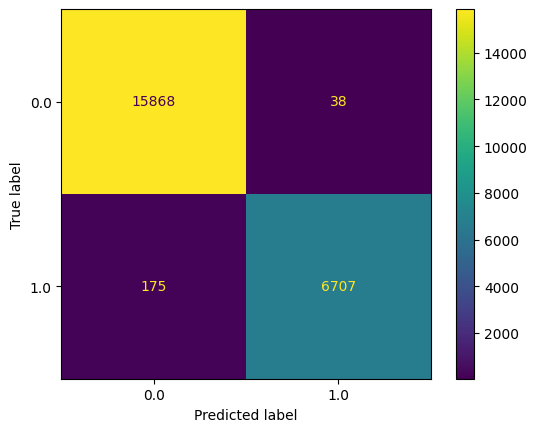

In [129]:
#confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=etc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=etc.classes_)
disp.plot()
plt.show()

In [130]:
precision = precision_score(y_val, y_pred)
print("Validation Precision:", precision)

Validation Precision: 0.9943661971830986


In [131]:
recall = recall_score(y_val, y_pred)
print("Validation Recall:", recall)

Validation Recall: 0.9745713455390874


In [132]:
fscore= (2*precision*recall)/(precision+recall)
print("Validation F score:", fscore)

Validation F score: 0.9843692668966023


In [134]:
lr_precision, lr_recall, _ = precision_recall_curve(y_val, lr_probs)
#lr_f1, lr_auc = f1_score(y_val, y_pred), auc(lr_recall, lr_precision)

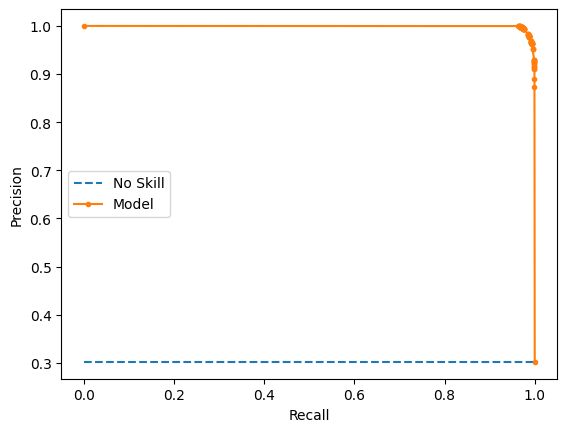

In [136]:
# plot the precision-recall curves
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Model')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## Obtaining the predictions for test dataset

In [137]:
X_test = testdf.iloc[:, :].values
y_test_pred = etc.predict(X_test)
y_test_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [138]:
testdata

,ID,KEYWORDS
0,115501,family practice drainage clinical dermatology ...
1,115502,general clinical operative medicine cardiology...
2,115503,abortion anxiety disorder apnea false trauma m...
3,115504,health male neurological surgery otolaryngolog...
4,115505,chronic kidney disease pain nephrology disease...
...,...,...
28488,143989,transplantation psychiatry heart failure angio...
28489,143990,small hospital nephrology emergency medicine r...
28490,143991,small hospital nephrology emergency medicine r...
28491,143992,the disease pain radiology lung abscess dyspar...


# Saving the predicted outputs as per the submission format

In [139]:
testdata["IS_HCP"] = y_test_pred
testdata = testdata[["ID", "IS_HCP"]]
testdata.to_csv("/content/drive/MyDrive/DOCEREE/submission.csv")